In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import skimage
from PIL import Image
import imgaug
from imgaug import augmenters as iaa
from skimage.filters import threshold_otsu
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

c:\programdata\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programdata\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programdata\anaconda3\envs\mask_rcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\programdata\anaconda3\envs\mask_rcnn\lib\site-packages\ten

keras version 2.2.5
tf version 1.12.0


In [2]:
# minimum input size = 128
class ShapesConfig(Config):
    # Give the configuration a recognizable name
    NAME = "skin"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16
    NUM_CLASSES = 1 + 2  # background + 2 types
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    RPN_ANCHOR_SCALES = (16,32,64,128,256)  # anchor side in pixels
    TRAIN_ROIS_PER_IMAGE = 8
    STEPS_PER_EPOCH = 626 // IMAGES_PER_GPU
    VALIDATION_STEPS = 626 // IMAGES_PER_GPU
    LEARNING_RATE = 0.001
    USE_MINI_MASK = False
    # gpu_options = True
config = ShapesConfig()
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class ShapesDataset(utils.Dataset):
    def list_images(self,data_dir):
        # define classes
        self.add_class("skin", 1, "fibroblast")
        self.add_class("skin", 2, "falsePositive")

        # data_dir = pathlib.Path('/home/kuki/Desktop/novo/')
        # register images
        train_images = list(data_dir.glob('*tile*/image/*.png'))
        print('# image in this dataset : ',len(train_images))
        for idx,train_image in enumerate(train_images):
            label = str(train_image).replace("image","mask")
            self.add_image("skin",image_id=idx,path=train_image,labelpath=label,
                           height=config.IMAGE_SHAPE[0],width=config.IMAGE_SHAPE[1])

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            print('grayscale to rgb')
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            print('rgba to rgb')
            image = image[..., :3]
        # image = cv2.resize(image,dsize=(256,256))
        return image.astype(np.uint8)

    # def load_mask(self, image_id):
    #     label = self.image_info[image_id]['labelpath']
    #     mask = np.load(label.replace('.tif','mask.npy'))
    #     class_ids = np.load(label.replace('.tif','classids.npy'))
    #     class_ids = class_ids + 1
    #     return mask,class_ids

    def load_mask(self, image_id):
        label = self.image_info[image_id]['labelpath']
        mask = Image.open(label)
        mask = np.array(mask).astype('int')
        mask = mask[:,:,np.newaxis]
        if 'false_positive' in label:
            class_ids = np.array([2])
        else:
            class_ids = np.array([1])
        return mask,class_ids


    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "skin":
            return info["truth"]
        else:
            super(self.__class__).image_reference(self, image_id)


In [3]:
data_dir = pathlib.Path(r'\\kukissd\Kyu_Sync\Aging\data\svs\20x\segmentation')
# CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_store"])
# print(CLASS_NAMES)
dataset_train = ShapesDataset()
dataset_train.list_images(data_dir)
dataset_train.prepare()

# image in this dataset :  626


In [4]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MAX_DIM = 128
inference_config = InferenceConfig()

In [5]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

keras version 2.2.5
tf version 1.12.0
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  C:\Users\kyuha\PycharmProjects\Mask_RCNN\logs\skin20200907T1807\mask_rcnn_skin_0030.h5
Re-starting from epoch 30


original_image           shape: (128, 128, 3)         min:   42.00000  max:  254.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  143.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   56.00000  max:   73.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  int32


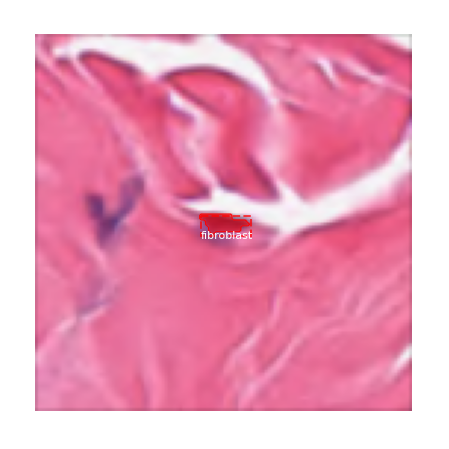

In [6]:
# Test on a random image
image_id = random.choice(dataset_train.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))

In [12]:
from PIL import Image
from skimage import io

src = r'\\kukissd\Kyu_Sync\Aging\data\svs\20x\segmentation\Wirtz.Denis_OTS-19_5021-003_false_positive_4\image'
dst = os.path.join(src,'classified')
if not os.path.exists(dst): os.mkdir(dst)

images = [os.path.join(src,_) for _ in os.listdir(src) if _.endswith('png')]
idd = []
for original_image in images:
    original_image2 = skimage.io.imread(original_image)
    results = model.detect([original_image2], verbose=1)
    r = results[0]
    masks = r['masks']
    masks = np.moveaxis(masks,2,0)
    if len(masks)<1:
        continue
    maskzero=np.zeros(masks[0].shape)
    for mask,id in zip(masks,r['class_ids']):
        idd.append(id)
        maskzero[mask]=id
    im = Image.fromarray(maskzero)
    im.save(os.path.join(dst, os.path.basename(original_image).replace('png','tif')))
print(idd)

Processing 1 images
image                    shape: (100, 100, 3)         min:   19.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -96.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -1.42535  max:    1.92141  float32
Processing 1 images
image                    shape: (100, 100, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -100.80000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -1.42535  max:    1.92141  float32
Processing 1 images
image                    shape: (100, 100, 3)         min:   21.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min:  -95.80000  max:  151.1